In [12]:
import os
import glob
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Adjust to your preferred style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [13]:
def parse_combined_json(json_path: str):
    """
    Parses a combined.json file, extracting coverage & atomicity from each entry.
    Tries to detect alignment_method, model, threshold by looking for specific
    substrings or patterns in the path.
    """
    # 1) Break the path into components
    parts = json_path.split(os.sep)
    
    # 2) Initialize fields to None
    alignment_method = None
    model_dir = None
    threshold_str = None
    threshold_val = None
    
    # You can adjust these lists to match your actual naming
    KNOWN_ALIGNMENT_METHODS = {"embedding", "entailment", "rouge"}
    KNOWN_MODELS = {"distilled_t5", "gpt-3.5-turbo", "llama2_7b"}
    
    # 3) Search each path component for clues
    for p in parts:
        # If it exactly matches a known alignment method:
        if p in KNOWN_ALIGNMENT_METHODS:
            alignment_method = p
        
        # If it exactly matches a known model name:
        if p in KNOWN_MODELS:
            model_dir = p
        
        # If it starts with "threshold_", parse the float portion
        if p.startswith("threshold_"):
            threshold_str = p.split("_", 1)[-1]  # e.g. "0.70"
            # Attempt to parse as float
            try:
                threshold_val = float(threshold_str)
            except ValueError:
                threshold_val = None  # or raise an error
    
    # 4) Load the JSON data
    with open(json_path, "r") as f:
        data = json.load(f)
    
    rows = []
    
    # 5) The data presumably has structure like: { "cnndm_test": [ {...}, {...} ] }
    # We'll iterate over dataset_name, then each item to get coverage/atomicity.
    for dataset_name, entries in data.items():
        # entries might be a list of dicts
        if isinstance(entries, list):
            for item in entries:
                coverage = item.get("coverage", None)
                atomicity = item.get("atomicity", None)
                
                row = {
                    "dataset": dataset_name,
                    "alignment_method": alignment_method,
                    "model": model_dir,
                    "threshold": threshold_val,
                    "coverage": coverage,
                    "atomicity": atomicity
                }
                rows.append(row)
        else:
            # If entries is not a list, handle accordingly
            pass
    
    return rows

In [14]:
base_path = "../metrics/alignment_results"  # Adjust if needed

all_records = []

# We'll look for combined.json in all subfolders
pattern = os.path.join(base_path, "**", "combined.json")
json_files = glob.glob(pattern, recursive=True)

for jf in json_files:
    records = parse_combined_json(jf)
    all_records.extend(records)

# Convert to DataFrame
df = pd.DataFrame(all_records)

print(f"Found {len(df)} entries total.")
df.head()


Found 191491 entries total.


,dataset,alignment_method,model,threshold,coverage,atomicity
0,cnndm_test,embedding,distilled_t5,0.7,0.800000,0.177778
1,cnndm_test,embedding,distilled_t5,0.7,0.636364,0.500000
2,cnndm_test,embedding,distilled_t5,0.7,0.777778,0.562500
3,cnndm_test,embedding,distilled_t5,0.7,0.500000,0.333333
4,cnndm_test,embedding,distilled_t5,0.7,1.000000,0.500000


In [15]:
# Compute average coverage & atomicity by method, model, threshold
group_cols = ["alignment_method", "model", "threshold"]

summary_df = (
    df.groupby(group_cols, as_index=False)
      .agg({
          "coverage": "mean",
          "atomicity": "mean",
      })
)

summary_df.sort_values(group_cols, inplace=True)
summary_df

,alignment_method,model,threshold,coverage,atomicity
0,embedding,distilled_t5,0.1,0.999677,0.187126
1,embedding,distilled_t5,0.2,0.998573,0.226668
2,embedding,distilled_t5,0.3,0.994708,0.286608
3,embedding,distilled_t5,0.4,0.982759,0.355196
4,embedding,distilled_t5,0.5,0.948513,0.433658
...,...,...,...,...,...
72,rouge,llama2_7b,0.3,0.923968,0.445777
73,rouge,llama2_7b,0.5,0.748850,0.611092
74,rouge,llama2_7b,0.7,0.447827,0.582470
75,rouge,llama2_7b,0.8,0.295892,0.446246


In [16]:
custom_palette = {
    "gpt-3.5-turbo": "#10A37F",     # Pale/brand green for OpenAI
    "llama2_7b":    "#1877F2",     # Blue for Meta
    "distilled_t5": "#FF0000"  # Red
}

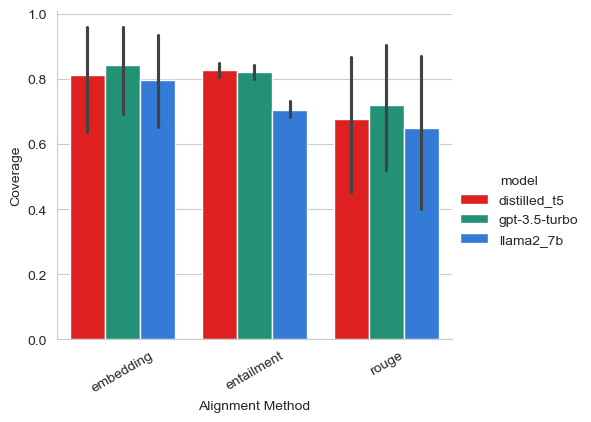

In [17]:
g = sns.catplot(
    data=summary_df, kind="bar",
    x="alignment_method", 
    y="coverage",
    hue="model", 
    # col="threshold",
    palette=custom_palette,
    height=4, 
    aspect=1.2
)

g.set_titles("Coverage")  
g.set_xlabels("Alignment Method")
g.set_ylabels("Coverage")
g.set_xticklabels(rotation=30)
plt.show()

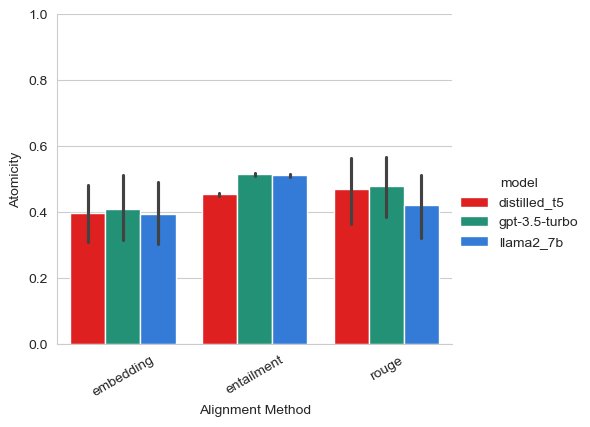

In [18]:
sns.set_style("whitegrid")

g = sns.catplot(
    data=summary_df, kind="bar",
    x="alignment_method", 
    y="atomicity",
    hue="model", 
    # col="threshold",
    palette=custom_palette,
    height=4, 
    aspect=1.2
)

g.set_titles("Atomicity")
g.set_xlabels("Alignment Method")
g.set_ylabels("Atomicity")
g.set_xticklabels(rotation=30)
g.set(ylim=(0, 1.0))
plt.show()

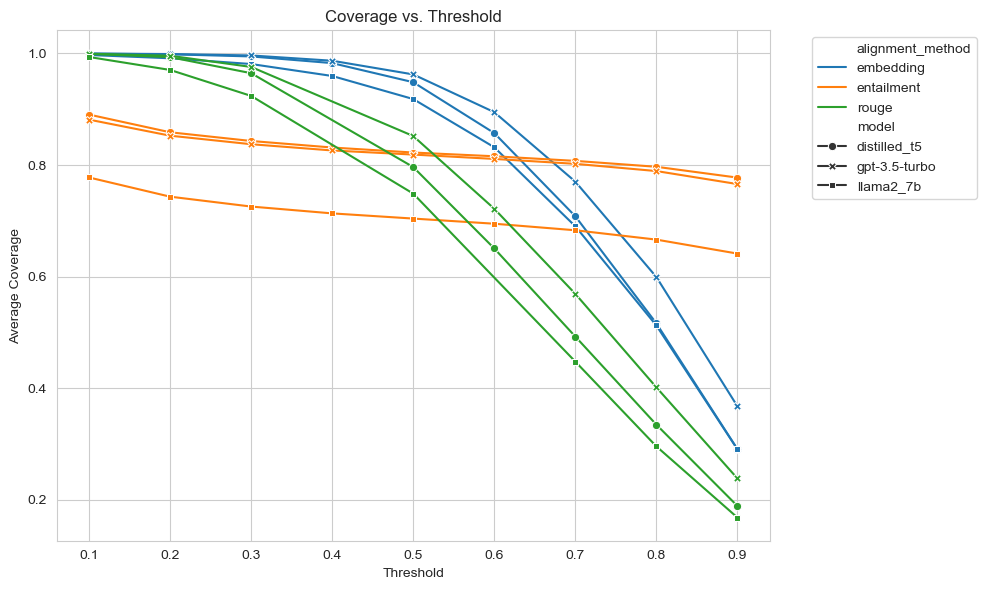

In [19]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=summary_df,
    x="threshold", y="coverage",
    hue="alignment_method",
    style="model",
    markers=True, dashes=False
)
plt.title("Coverage vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average Coverage")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

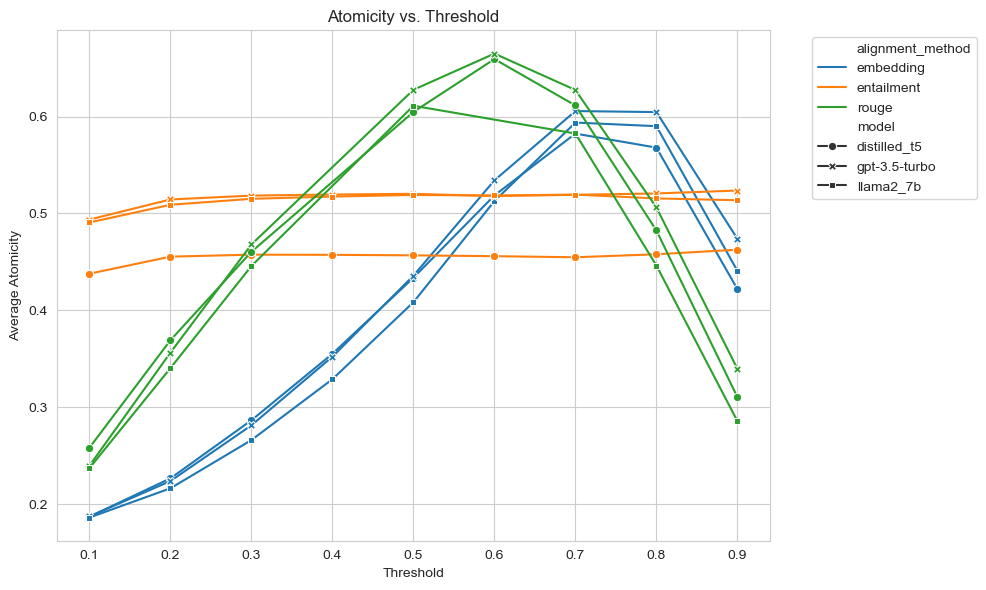

In [20]:
plt.figure(figsize=(10,6))

sns.lineplot(
    data=summary_df,
    x="threshold", y="atomicity",
    hue="alignment_method",
    style="model",
    markers=True, dashes=False
)
plt.title("Atomicity vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average Atomicity")
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
